In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tau_classification/')

from base import *
from constants import *
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/')

from tuning import * 
from extra_metrics_training import *
from tuning_constants import * 

In [2]:
import joblib

In [3]:
import pandas as pd
import numpy as np 
import random 

from sklearn import preprocessing 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [11]:
path = "C:/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tau_classification/Untrained/Training_data/STN&GP/"
filename = "training.txt"

# Create tau database object 
stn_gp_data = TauDataBase(path = path,
                      filename = filename) 

# Prepping data to train tau classifier for dentate nucleus
stn_gp_data.classifier2_prep()

# Check data
print(stn_gp_data.c2_data['Class'].value_counts())
print(stn_gp_data.c2_X_train.shape)

Others    12988
CB          601
NFT          97
Name: Class, dtype: int64
(13686, 54)


In [10]:
# Tuning 
rf_random = RandomizedSearchCV(pipeline,
                               param_distributions=random_grid, 
                               n_iter=100,
                               cv=10,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1,
                               refit='PR_AUC',
                               scoring={
                                'PR_AUC':precision_recall_auc_tau_noTA,
                                'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                                'roc_auc_ovo':'roc_auc_ovo',
                                'balanced_accuracy':'balanced_accuracy',
                                'f1_weighted':'f1_weighted',
                                'CB_accuracy': CB_acc_noTA,
                                'NFT_accuracy':NFT_acc_noTA,
                                'Others_accuracy':Others_acc_noTA
                                        })

rf_random.fit(stn_gp_data.c2_X_train,
              stn_gp_data.c2_Y_train)


print(rf_random.best_score_)
print(rf_random.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.9722748280702873
{'selector__n_features_to_select': 34, 'clf__sampling_strategy': 'not majority', 'clf__random_state': 42, 'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.75, 'clf__max_features': 0.6, 'clf__max_depth': 15, 'clf__class_weight': 'balanced'}


In [13]:
# Digging into more details 
print("PR-AUC:",
      rf_random.cv_results_['mean_test_PR_AUC'][rf_random.best_index_]*100)
print("ROC-AUC:",
      rf_random.cv_results_['mean_test_roc_auc_ovr_weighted'][rf_random.best_index_]*100)
print("ROC-AUC:",
      rf_random.cv_results_['mean_test_roc_auc_ovo'][rf_random.best_index_]*100)

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("CB accuracy:",
      rf_random.cv_results_['mean_test_CB_accuracy'][rf_random.best_index_]*100)

print("NFT accuracy:",
      rf_random.cv_results_['mean_test_NFT_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)

# print("Classified CB as NFT:",
#       rf_random.cv_results_['mean_test_CB_as_NFT'][rf_random.best_index_]*100)

# print("Classified CB as Others:",
#       rf_random.cv_results_['mean_test_CB_as_Others'][rf_random.best_index_]*100)

# print("Classified NFT as CB:",
#       rf_random.cv_results_['mean_test_NFT_as_CB'][rf_random.best_index_]*100)

# print("Classified NFT as Others:",
#       rf_random.cv_results_['mean_test_NFT_as_Others'][rf_random.best_index_]*100)

# print("Classified Others as CB:",
#       rf_random.cv_results_['mean_test_Others_as_CB'][rf_random.best_index_]*100)

# print("Classified Others as NFT:",
#       rf_random.cv_results_['mean_test_Others_as_NFT'][rf_random.best_index_]*100)

                                                       

PR-AUC: 97.22748280702874
ROC-AUC: 99.58744381409629
ROC-AUC: 98.89347152558356
Balanced accuracy: 85.45460243381464
F1_weighted: 97.82661783188965
CB accuracy: 58.55191256830601
NFT accuracy: 97.88888888888889
Others accuracy: 99.92300584424903


In [12]:
# save object using joblib
joblib.dump(rf_random, 'stn_gp_random_search.sav')

['stn_gp_random_search.sav']

{'selector__n_features_to_select': 34, 'clf__sampling_strategy': 'not majority', 'clf__random_state': 42, 'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_samples': 0.75, 'clf__max_features': 0.6, 'clf__max_depth': 15, 'clf__class_weight': 'balanced'}


In [15]:
stn_gp_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(RandomForestClassifier(
        random_state=42),
        n_features_to_select=34)),
    ('clf', BalancedRandomForestClassifier(
        random_state=42,
        sampling_strategy='not majority',
        n_estimators=500,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features=0.6,
        max_depth=15,
        max_samples=0.75,
        class_weight='balanced'))]
        
# 10-fold cross validation
model = TauClassifierNoTATuning(hyperparameters=stn_gp_classifier_hyperparams)
model.find_bestparameters(X=stn_gp_data.c2_X_train,
                          Y=stn_gp_data.c2_Y_train)


In [16]:
model.best_parameters

{0: (0.18845399342448405,
  0.8946962279425845,
  0.8965841716432827,
  0.9002459016393443),
 1: (0.7187865615771717,
  0.9529564106344293,
  0.9518181818181819,
  0.9588888888888889),
 2: (0.774700336310272,
  0.9956218336556081,
  0.9939498939499222,
  0.9973053231655025)}

In [17]:
model.cv_withthresholding(best_parameters=model.best_parameters,
                          X=stn_gp_data.c2_X_train,
                          Y=stn_gp_data.c2_Y_train,
                          X_location=stn_gp_data.c2_train_location)


In [18]:
# Confusion matrix across 10 folds, WITH thresholding 
print('with thresholding (non-calibrated) ACC :', mean(model.cv_accuraciesT)*100)
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reportsT])*100)
print("--------------------------")
cf_t = sum(model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100
print(cf_t)
print(final_cm_t)
print("--------------------------")
print("CB accuracy",final_cm_t[0][0])
print("NFT accuracy",final_cm_t[1][1])
print("Others accuracy",final_cm_t[2][2])
print('------------------------------')
# F1-score per class: 
print('CB f1-score ',mean([i['CB']['f1-score'] for i in model.cv_reportsT])*100)
print('CB precision ',mean([i['CB']['precision'] for i in model.cv_reportsT])*100)
print('CB recall ',mean([i['CB']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('NFT f1-score ',mean([i['NFT']['f1-score'] for i in model.cv_reportsT])*100)
print('NFT precision ',mean([i['NFT']['precision'] for i in model.cv_reportsT])*100)
print('NFT recall ',mean([i['NFT']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reportsT])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reportsT])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

with thresholding (non-calibrated) ACC : 91.70069896154904
Macro avg F1  92.9655774203556
Weighted avg F1  98.95283661544583
--------------------------
[[  509     4    74]
 [   10    79     0]
 [   53     0 12920]]
[[86.7120954   0.68143101 12.60647359]
 [11.23595506 88.76404494  0.        ]
 [ 0.40854082  0.         99.59145918]]
--------------------------
CB accuracy 86.71209540034071
NFT accuracy 88.76404494382022
Others accuracy 99.59145918446004
------------------------------
CB f1-score  87.7236378113181
CB precision  88.9912614256301
CB recall  86.74482963692107
--------------------------
NFT f1-score  91.66196978116483
NFT precision  95.64213564213564
NFT recall  88.76587301587303
--------------------------
Others f1-score  99.51112466858389
Others precision  99.43167173995795
Others recall  99.59139423185303
--------------------------
Macro avg precision 94.68835626924124
Macro avg recall  91.70069896154904


In [19]:
model.cv_nothresholding(X=stn_gp_data.c2_X_train,
                        Y=stn_gp_data.c2_Y_train,
                        X_location=stn_gp_data.c2_train_location)

In [20]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("CB accuracy",final_cm[0][0])
print("NFT accuracy",final_cm[1][1])
print("Others accuracy",final_cm[2][2])
print('------------------------------')
# F1-score per class: 
print('CB f1-score ',mean([i['CB']['f1-score'] for i in model.cv_reports])*100)
print('CB precision ',mean([i['CB']['precision'] for i in model.cv_reports])*100)
print('CB recall ',mean([i['CB']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('NFT f1-score ',mean([i['NFT']['f1-score'] for i in model.cv_reports])*100)
print('NFT precision ',mean([i['NFT']['precision'] for i in model.cv_reports])*100)
print('NFT recall ',mean([i['NFT']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 85.45460243381464
Macro avg F1  86.9573793460781
Weighted avg F1  97.82661783188965
--------------------------
[[  352    20   229]
 [    2    95     0]
 [   10     0 12978]]
[[5.85690516e+01 3.32778702e+00 3.81031614e+01]
 [2.06185567e+00 9.79381443e+01 0.00000000e+00]
 [7.69941484e-02 0.00000000e+00 9.99230059e+01]]
--------------------------
CB accuracy 58.56905158069884
NFT accuracy 97.9381443298969
Others accuracy 99.92300585155527
------------------------------
CB f1-score  71.80122481047741
CB precision  96.52893680800658
CB recall  58.55191256830601
--------------------------
NFT f1-score  89.98244040699284
NFT precision  84.01931401931402
NFT recall  97.88888888888889
--------------------------
Others f1-score  99.08847282076408
Others precision  98.2696422029182
Others recall  99.92300584424905
--------------------------
Macro avg precision 92.93929767674626
Macro avg recall  85.45460243381464


In [21]:
# save object using joblib
joblib.dump(model, 'stn_gp_cv_results.sav')

['stn_gp_cv_results.sav']

In [5]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/Final/results/stn_gp_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

In [6]:
# find out proportion of ambiguous cells 
predicted = (sum(loaded_model.cv_y_predictsT, []))
print('total:',len(predicted))
print(set(predicted))
amb_n = sum(1 for i in predicted if i =='Ambiguous')
print('Ambiguous: ',amb_n)
print('proportion Ambiguous: ', amb_n/len(predicted) )

total: 13686
{'Ambiguous', 'NFT', 'Others', 'CB'}
Ambiguous:  37
proportion Ambiguous:  0.0027034926201958205


In [7]:
loaded_model.best_parameters

{0: (0.18845399342448405,
  0.8946962279425845,
  0.8965841716432827,
  0.9002459016393443),
 1: (0.7187865615771717,
  0.9529564106344293,
  0.9518181818181819,
  0.9588888888888889),
 2: (0.774700336310272,
  0.9956218336556081,
  0.9939498939499222,
  0.9973053231655025)}

In [8]:
final_cm_t

array([[86.7120954 ,  0.68143101, 12.60647359],
       [11.23595506, 88.76404494,  0.        ],
       [ 0.40854082,  0.        , 99.59145918]])

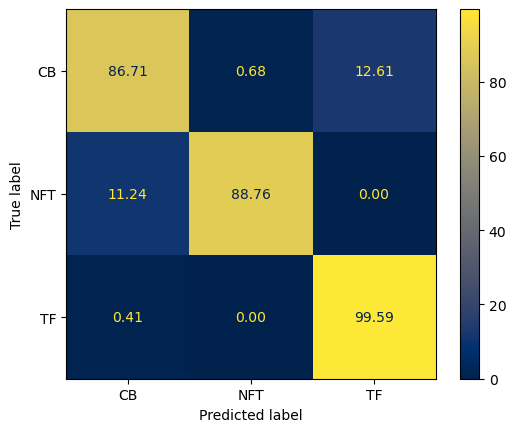

In [13]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['CB','NFT','TF'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [14]:
model = loaded_model
# Confusion matrix across 10 folds, WITH thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

Macro avg F1  92.9655774203556
Macro avg F1 std  2.656785212034748
--------------------------
Macro avg precision 94.68835626924124
Macro avg precision std 2.6462475281240327
--------------------------
Macro avg recall  91.70069896154904
Macro avg recall std 4.198626381898822


In [15]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  86.9573793460781
Macro avg F1 std  6.050319663205212
--------------------------
Macro avg precision 92.93929767674626
Macro avg precision std 3.8440733147390085
--------------------------
Macro avg recall  85.45460243381464
Macro avg recall std 5.616623828711429


Plotting feature importance

In [16]:
import seaborn as sns

In [17]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/Final/scripts/stn_gp_random_search.sav')

In [18]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [stn_gp_data.c2_X_train.columns[i] for i in rf_result]
# (rf_result_f)
importance = model_rf.best_estimator_.named_steps['clf'].feature_importances_
f_importance = pd.DataFrame(data={'features':rf_result_f,'importance':importance})
f_importance = f_importance.sort_values(by=['importance'],ascending=False)

In [19]:
f_importance_subset = f_importance[0:11]
features = [i.replace('ROI: 0.25 µm per pixel: ','') for i in f_importance_subset['features']]
f_importance_subset = f_importance_subset.copy()
f_importance_subset.loc[:,'features'] = features
f_importance_subset = f_importance_subset.rename(columns={'features':'Feature',
                                    'importance':'Importance'})

In [20]:
f_importance_subset

,Feature,Importance
0,Area µm^2,0.510403
4,Min diameter µm,0.193240
21,DAB: Mean,0.074044
3,Max diameter µm,0.031333
33,Solidity,0.028362
17,DAB: Haralick Sum average (F5),0.017806
2,Length µm,0.016333
13,DAB: Haralick Correlation (F2),0.016182
22,DAB: Median,0.013722
18,DAB: Haralick Sum entropy (F7),0.011604


<Axes: xlabel='Importance', ylabel='Feature'>

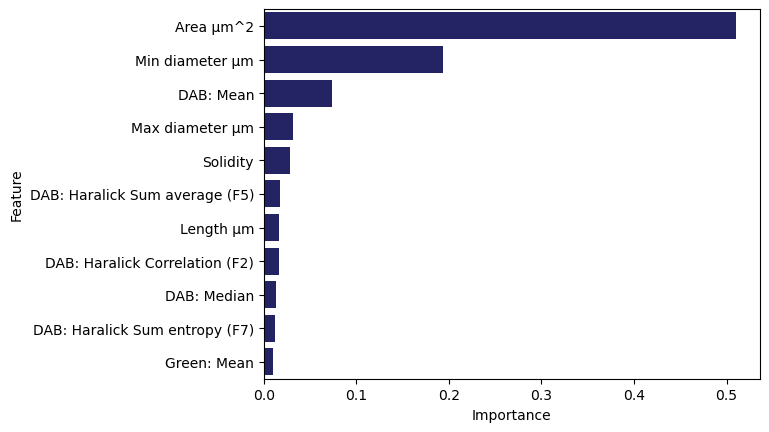

In [21]:
sns.barplot(data=f_importance_subset,
            y="Feature",
            x="Importance",
            color='midnightblue')

Finding PR-AUC

In [22]:
keys = ['split0_test_PR_AUC',
        'split1_test_PR_AUC',
        'split2_test_PR_AUC',
        'split3_test_PR_AUC',
        'split4_test_PR_AUC',
        'split5_test_PR_AUC',
        'split6_test_PR_AUC',
        'split7_test_PR_AUC',
        'split8_test_PR_AUC',
        'split9_test_PR_AUC']
pr_val = []
for i in keys:
    pr_val.append(model_rf.cv_results_[i][model_rf.best_index_])

In [23]:
print(model_rf.cv_results_['mean_test_PR_AUC'][model_rf.best_index_]*100)
print('mean pr:', mean(pr_val)*100)
print('std pr:', np.std(pr_val)*100)

97.22748280702874
mean pr: 97.22748280702874
std pr: 2.003747264593253
